# New York City Airbnb listings pricing prediction

## Students:
- Alon Avrahami 312188972
- Ido Aharon 319024600

In [ ]:
%pip install -r requirements.txt

In [2]:
# User configurations:
run_alternative_models = False
run_hyperparameter_tuning = False

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import time

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from PIL import Image

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
data_path = "Data/NYC_Airbnb_dataset"

airbnb = pd.read_csv(f"{data_path}/AB_NYC_2019.csv") 

# Basic Data Preprocessing
We observe all the samples that have a missing values in the dataset, and will fill a default value for the missing values in the dataset or dropping the rows that have important missing values.

In [5]:
# Fill the missing values with the default value (0) in the "reviews_per_month" column
airbnb["reviews_per_month"] = airbnb["reviews_per_month"].fillna(0)

In [6]:
# Removing the "id" column from the dataset, as it is not useful for our analysis, and we already have the dataframe index.
# Removing the "host_name" column, we already have the host_id which is a unique identifier for the host.
# Removing the "last_review" column from the dataset, as we don't have any use for it, some of the samples have missing values in this column, and the dataset is only for the year 2019, so we don't need the last review date
# Removing the "name" column from the dataset, as we don't have any use for it, it holds unique names for each listing, and we couldnt find any word occurances that relate to the price
airbnb = airbnb.drop(["id", "host_name", "last_review", "name"], axis=1)

# Exploratory Data Analysis
Exploration of the data and understanding the relationships between the different features in the dataset.

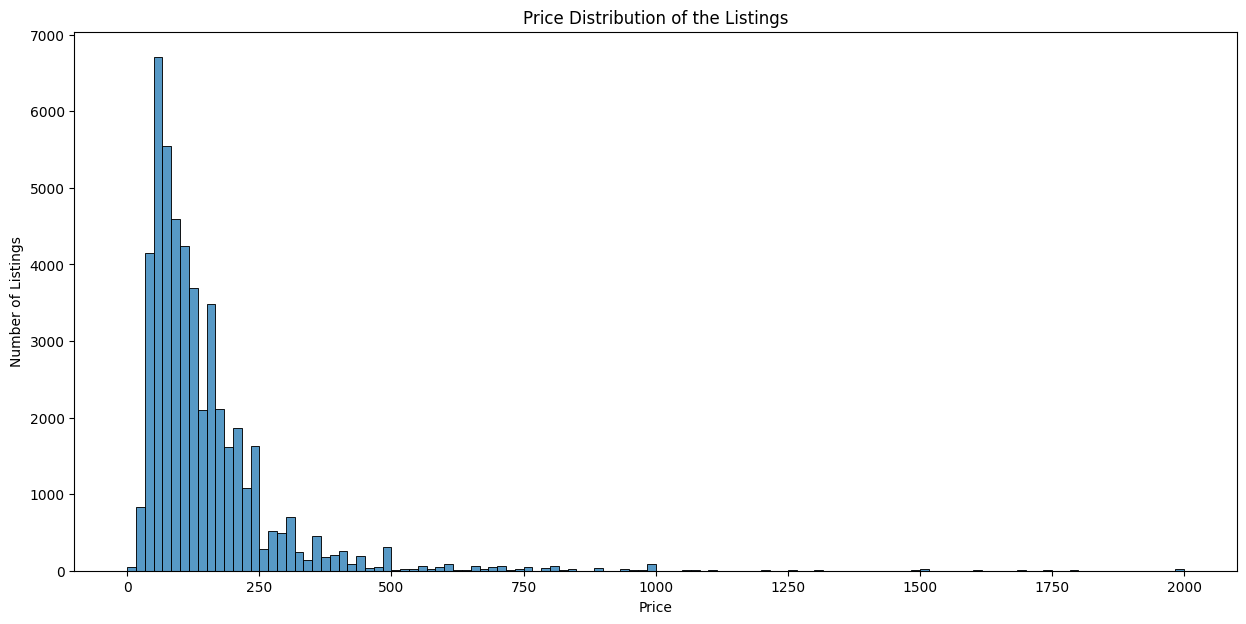

In [7]:
# Plot the distribution of the prices of the listings in the dataset
plt.figure(figsize=(15, 7))
sns.histplot(airbnb[airbnb.price <= 2000].price, bins=120, kde=False)
plt.title("Price Distribution of the Listings")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.show()

Its easy to see that the price distribution is right-skewed, with most of the listings having a price of less than 500 USD, and a few listings having a price of more than 500 USD.\
We will remove the listings that have a price of more than 500 USD, and also listings than have an invalid price 0, then plot the distribution of the prices again.

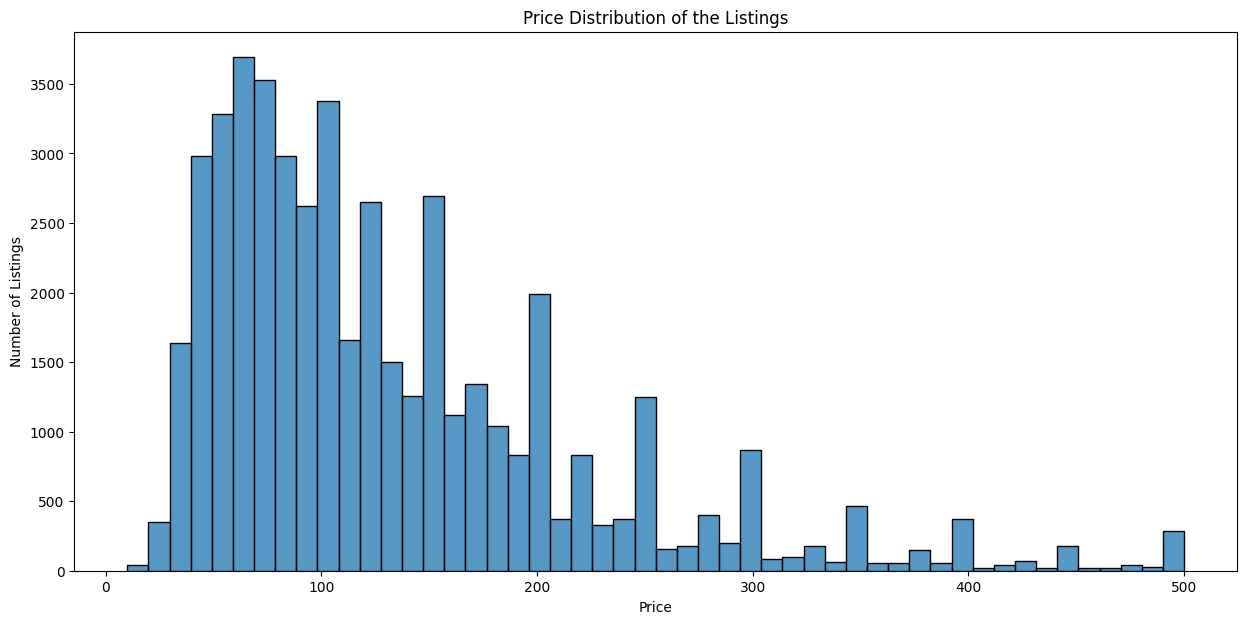

In [8]:
# Remove the listings that have a price of more than 500 and pricing higher than 0
airbnb = airbnb[airbnb.price <= 500]
airbnb = airbnb[airbnb.price > 0]

# Plot the distribution of the prices of the listings in the dataset
plt.figure(figsize=(15, 7))
sns.histplot(airbnb.price, bins=50, kde=False)
plt.title("Price Distribution of the Listings")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.show()

After removing the outliers, it seems like the distribution is less skewed, but we still have a wide range of pricing, we will try to use data transformation to lower the range of the pricing in the pre-processing part.

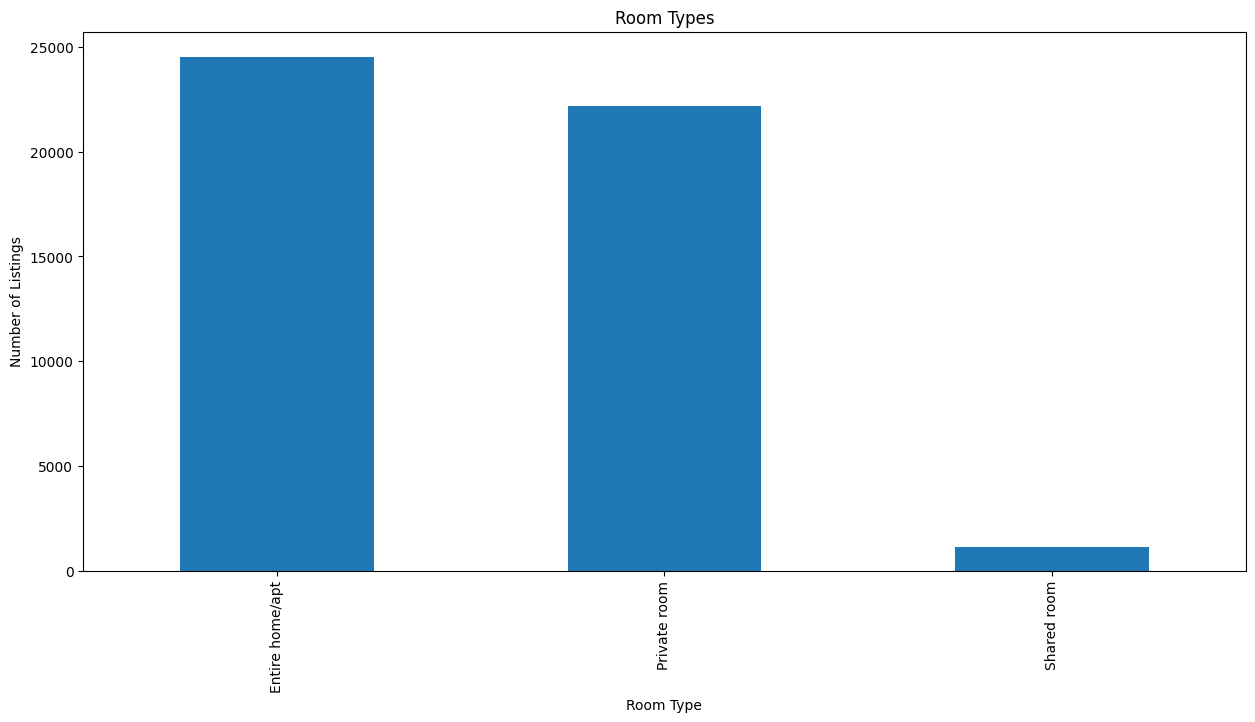

In [9]:
# Plot the distribution of the room types
room_types = airbnb.room_type.value_counts()
room_types.plot(kind="bar", figsize=(15, 7))
plt.title("Room Types")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")
plt.show()

As we can see, the most popular room type is entire home / apartment, which basically costs more than a shared room or a private room.\
It may be because most people are looking for a long-term aparment for a family rather than a few smaller rooms to save on the overall price.

Now, let's plot the distributions of the most popular neighborhood groups in New York, which are *Manhattan*, *Brooklyn*, *Queens*, *Bronx* and *Staten Island*.

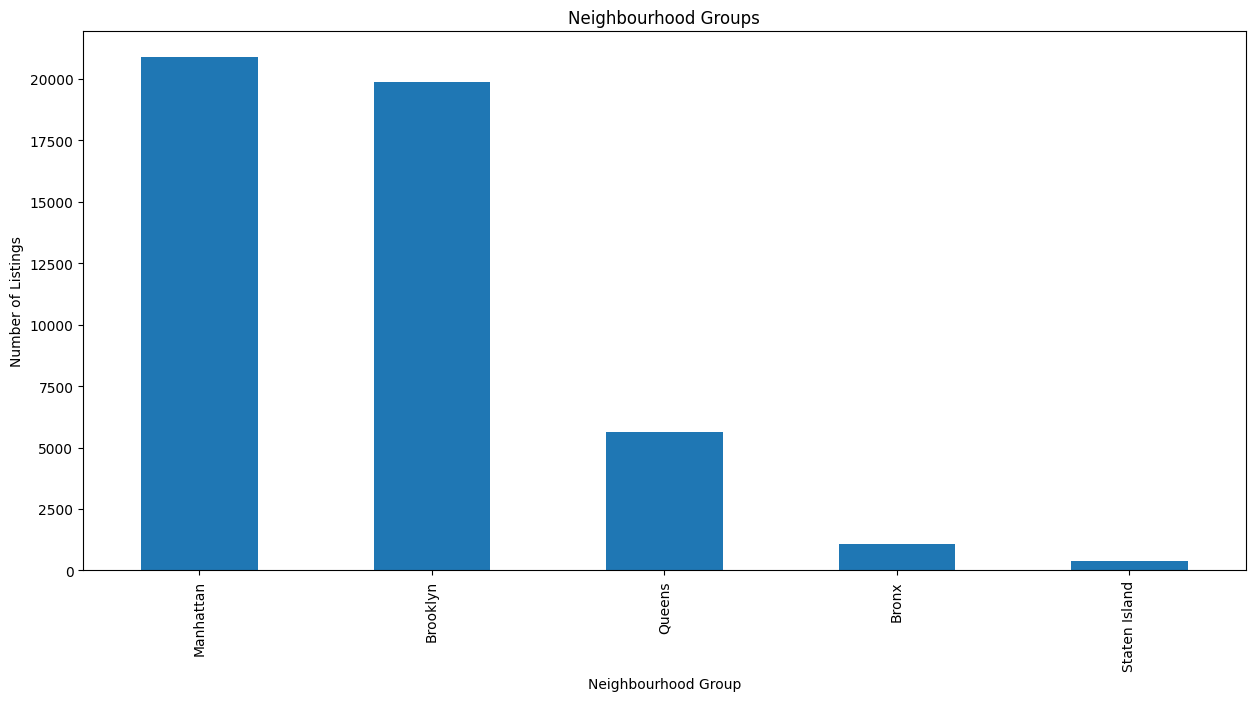

In [10]:
# Plot the distribution of the neighbourhood groups
neighbourhood_groups = airbnb.neighbourhood_group.value_counts()
neighbourhood_groups.plot(kind="bar", figsize=(15, 7))
plt.title("Neighbourhood Groups")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Number of Listings")
plt.show()

We can see that most of the available listings are located in Manhattan or Brooklyn. We have quite a few listings in Queens as well, and the rest are in Bronx and Staten Island which are less popular.

Looking at the categorial featuers, we can see that the feature **room_type** has 3 different values, so we will use one-hot-encoder instead of the actual category.\
Also, the feature **neighbourhood_group** has 5 different values, so we will also apply one-hot-encoder.

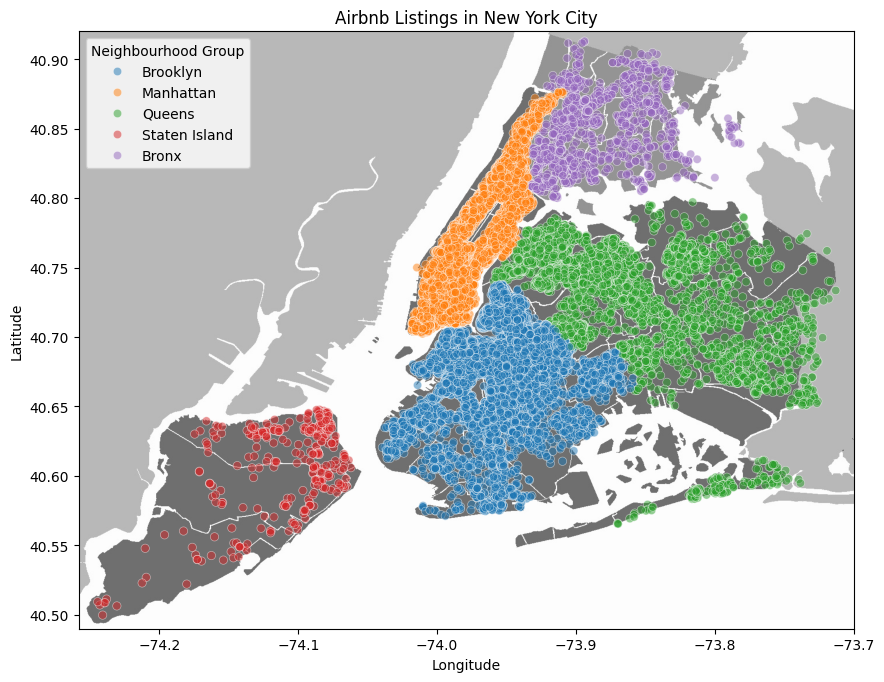

In [11]:
# Plot all the listing locations on a map of New York City using the latitude and longitude columns as coordinates
plt.figure(figsize=(10, 10))
img = Image.open(f"{data_path}/New_York_City_.png")
plt.imshow(img, extent=[-74.258, -73.7, 40.49, 40.92])
sns.scatterplot(x="longitude", y="latitude", data=airbnb, hue="neighbourhood_group", alpha=0.5, color="bright")
plt.title("Airbnb Listings in New York City")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Neighbourhood Group")
plt.show()

As we explained earlier, it is visually clear that the majority of the listings are located in Manhattan (Center of the map), then Brooklyn, followed by Queens, Bronx, and Staten Island.\
The map also shows that the majority of the listings are located in the southern part of Manhattan, and the northern part of Brooklyn (very dense).\
The reasons for this could be related to the distance from the central-park, the  Empire State Building, and the Statue of Liberty, which are very popular interest points for tourists.

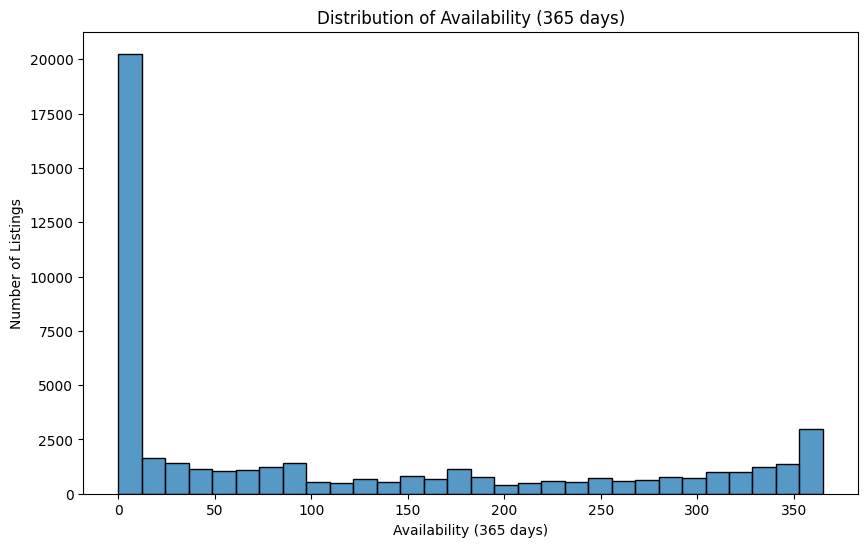

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(airbnb["availability_365"], bins=30, kde=False)
plt.title("Distribution of Availability (365 days)")
plt.xlabel("Availability (365 days)")
plt.ylabel("Number of Listings")
plt.show()

As we can see, we have a lot of listings with 0 availability. In the feature engineering part, we will try to estimate the actual availability based on reviews, trying to get more meaningful feature.

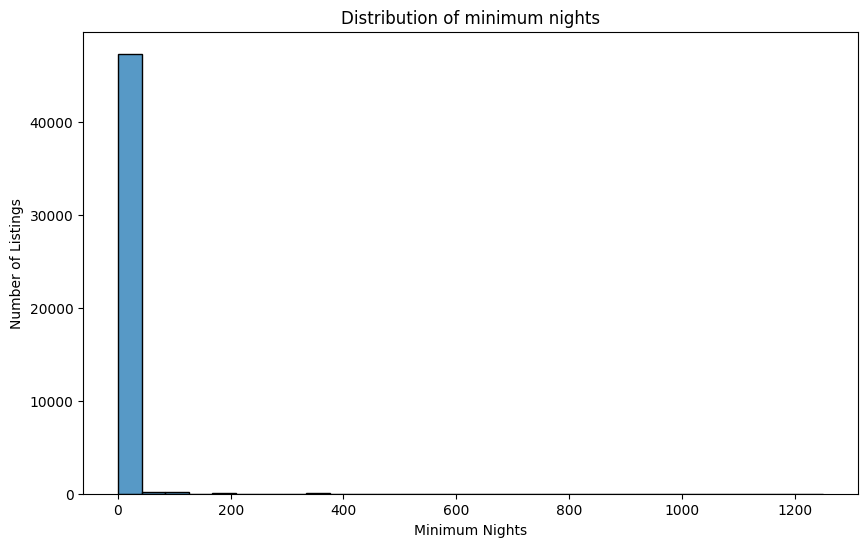

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(airbnb["minimum_nights"], bins=30, kde=False)
plt.title("Distribution of minimum nights")
plt.xlabel("Minimum Nights")
plt.ylabel("Number of Listings")
plt.show()

As can be seen in the diagram, most of the listings have minimum of 1 night per stay, however, in a very small amount of listings we have a minimum of nights higher than the number of days in a year (365).\
This is affecting our posibility to create annoual related features, so we decided to drop these listings.

# Pre Processing

In the preprocess phase we would like to add new features that will help us to better predict the listings prices.\
For this, we will add **max_yearly_bookings**, which indicates how many times a year this listing is available, and **booking_rate**, which indicates how many times a year this listing is booked in average.

In addition, we want to avoid noises in the *fit* phase, so we delete the listings that have a minimum nights greater than 365 days.

In [14]:
# Number of listings with minimum nights greater than 365
print("Listings with minimum nights greater than 365: ", airbnb[airbnb.minimum_nights > 365].shape[0])

# Drop the rows that have a minimum nights greater than 365
airbnb = airbnb[airbnb.minimum_nights <= 365]

# Creating new feature "max_yearly_bookings" which may help us to understand the potential income per year
airbnb["max_yearly_bookings"] = 365 / airbnb["minimum_nights"]

# Creating new feature booking
airbnb["booking_rate"] = 365 - airbnb["availability_365"]

Listings with minimum nights greater than 365:  14


#### Transformations

Applying transformation on the price column to handle the skewness, and to improve the model ability to predict the price by lowering the range of prices he need to predict, as the range of (0-500] is quite big, to applying the transformation will help us to improve the model prediction.
We decided to check 3 different transformations:
- **log1p** - Natural logarithm of one plus the input (avoid error with 0)
- **BoxCox** - Box-Cox power transformation
- **Yeo-Johnson** - Yeo-Johnson power transformation

Results:\
After applying all 3 of the transformations on our data, we saw a litle performance improvment using the **Yeo-Johnson transformation**.

In [15]:
# # Use BoxCox transformation to the price column to make the distribution of the prices more normally distributed
# from scipy.stats import boxcox
# airbnb["price"], price_lambda = boxcox(airbnb.price)

In [16]:
# Use log transformation to the price column to make the distribution of the prices more normally distributed
# airbnb["price"] = np.log1p(airbnb.price)

In [17]:
# Use Yeo-Johnson transformation to the price column to make the distribution of the prices more normally distributed
from scipy.stats import yeojohnson
airbnb["price"], price_lambda = yeojohnson(airbnb.price)

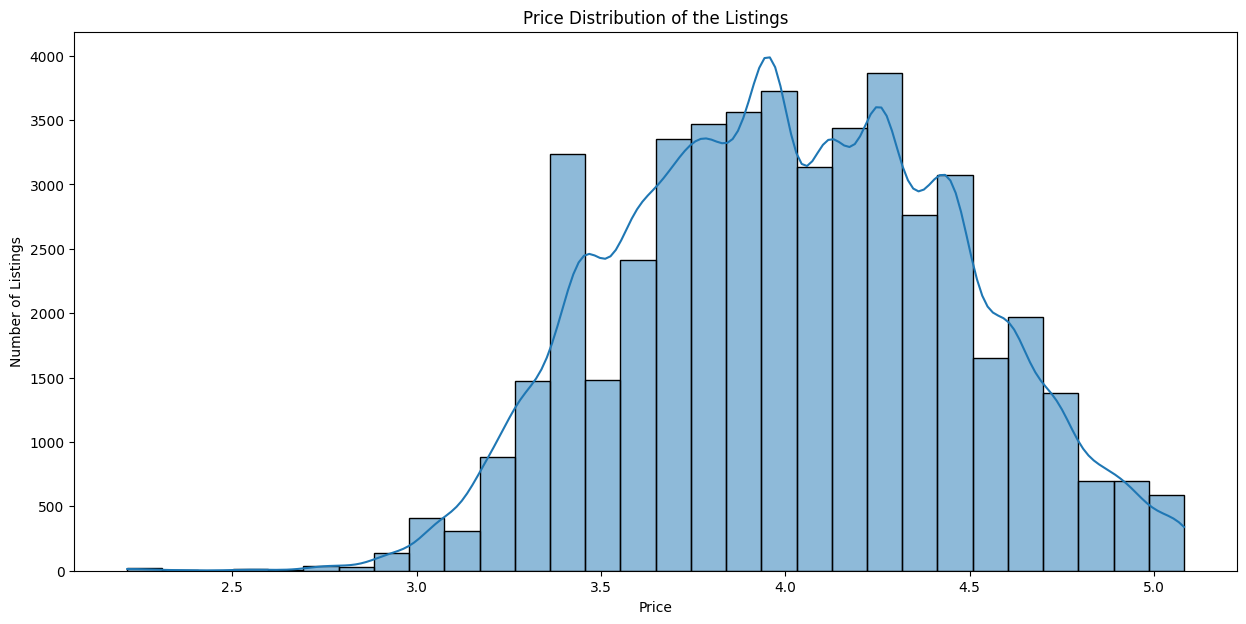

In [18]:
# Plot the distribution of the prices of the listings in the dataset after the Yeo-Johnson transformation
plt.figure(figsize=(15, 7))
sns.histplot(airbnb.price, bins=30, kde=True)
plt.title("Price Distribution of the Listings")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.show()

Now, after applying the **Yeo-Johnson transformation**, we can see that the price distribution is better, with most listings pricing around 4.0, with smaller skewness and with smaller range of values.

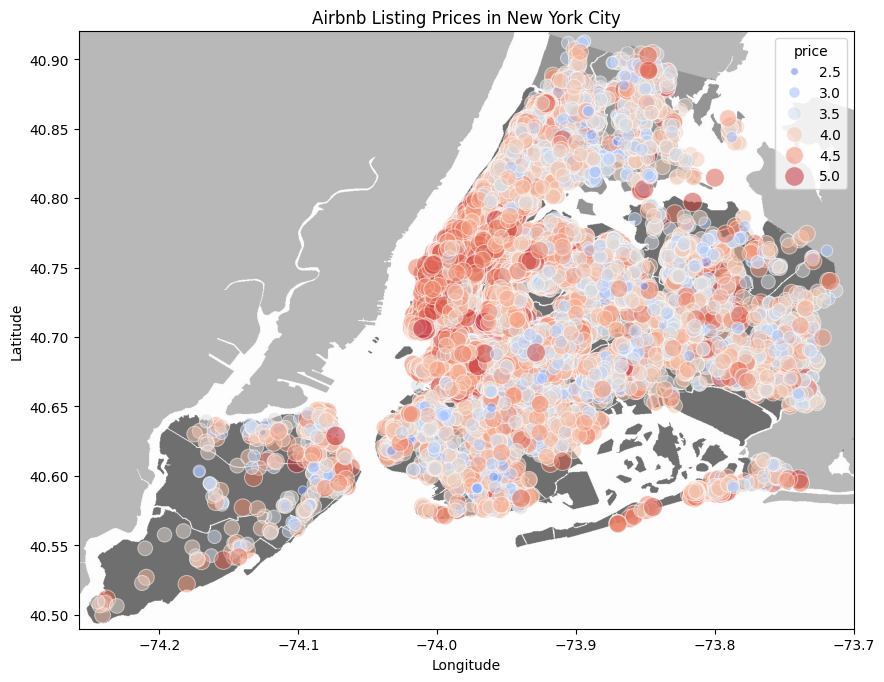

In [19]:
# Now plot the distribution of the prices of the listings in the dataset in the map of New York City
plt.figure(figsize=(10, 10))
img = Image.open(f"{data_path}/New_York_City_.png")
plt.imshow(img, extent=[-74.258, -73.7, 40.49, 40.92])
sns.scatterplot(x="longitude", y="latitude", data=airbnb, hue="price", size="price", sizes=(10, 200), alpha=0.5, palette="coolwarm")
plt.title("Airbnb Listing Prices in New York City")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Using the map of New York City, we can see that the majority of the listings are located in Manhattan (Center of the map), and the prices of the listings are higher in Manhattan compared to the other neighbourhood groups.\
Bigger cirecles meaning higher price.

Now, let's apply a label encoder to the **neighborhood** column. It is better than One-Hot Encoding in this scenario, because the **neighboorhood** column has 219 different values, and One-Hot Encoding will create too many new columns. Hence, we prefer to use the label encoder that maps each category to a number indicator.

In [20]:
# Applying Label Encoding to the "neighbourhood" column, as it has 219 different values, and One-Hot Encoding will create a lot of new columns.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
airbnb["neighbourhood"] = label_encoder.fit_transform(airbnb["neighbourhood"])

#### Data Imputation


Our **availability_365** feature may have some missing information, and sometime shows invalid values, so we tried to estimate a better availability instead of using a default number (0).\
This is another prediction problem, but we saw that this data manipulation (as we do in the next cells) actually helps to improve our model prediction, and the relevant feature also has higher SHAP value.

In [21]:
# from sklearn.impute import KNNImputer

# airbnb_columns = airbnb.columns
# airbnb["availability_365"] = airbnb.availability_365.replace(0, np.nan) # by default, KNNImputer replace "np.nan" with the imputation value.

# # Initialize the KNNImputer
# imputer = KNNImputer(n_neighbors=5)

# # Impute missing values or 0 in the dataset
# airbnb = imputer.fit_transform(airbnb)

# # Convert the imputed array back to a DataFrame
# airbnb = pd.DataFrame(airbnb, columns=airbnb_columns)

We have tried to use KNN Imputation to fill the missing values (0) based on clustring algorithem.\
However, we saw a degradation in the model performance using the KNN Imputation, therefore, we have decided to fill the missing values with the median of each group.

In [22]:
# for each listing in the same neighbourhood and the same room type, calculate the median of availability_365, and if availability_365 is 0, then set it to the median value
airbnb["availability_365"] = airbnb.groupby(["neighbourhood_group", "room_type"])["availability_365"].transform(lambda x: x.replace(0, x.median()))

#### Categorial features embedding
We have tried to implement embedding vector using Word2Vec to the **neighbourhood** feature, as it includes more than 200 different neighbourhoods, therefore, we thought it may worth trying to use embedding vector to each of the neighbourhood's name, and understand if we can represent them as embedding vector.

In [23]:
# from gensim.models import Word2Vec

# # Split the neighbourhood column into words
# airbnb["neighbourhood"] = airbnb["neighbourhood"].str.split()

# # Train the Word2Vec model
# model = Word2Vec(airbnb["neighbourhood"], vector_size=1, window=5, min_count=1, workers=4)

# # Vector representation of each neighbourhood
# airbnb["neighbourhood"] = airbnb["neighbourhood"].apply(lambda x: np.mean([model.wv[word] for word in x], axis=0))
# airbnb["neighbourhood"] = airbnb["neighbourhood"].astype(float)

We saw a degradation in the model performance using the Word2Vec embedding method, therefore, we decided to use the Label Encoder.

In [24]:
# Applying One-Hot Encoding to the categorical columns
airbnb = pd.get_dummies(airbnb, columns=["neighbourhood_group", "room_type"], prefix=["neighbourhood_group", "room_type"])

In contrast to the **neighborhood** column, which has 219 different values, the *neighbo*rhood_group* has only a few diffrent values, so in this scenrio we prefer to use the One-Hot Encoding.\
We also applying the One-Hot Encoding on the **room_type** feature as it has only 3 options.

In [25]:
# Normalize the "availability_365" column by dividing it by 365, as it represents the availability in days per year, and we want to normalize it to be between 0 and 1.
airbnb["availability_365"] = airbnb["availability_365"] / 365

The **availability_365** column is a categorial feature (it has 365 possible values) so we normlized it by diving by 365 (number of days per year).\
The other features are numeric, so we will use RobustScaler in order to normalize it.

In [26]:
# Normalizing the numerical features using RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
numerical_columns = ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "latitude", "longitude"]
airbnb[numerical_columns] = scaler.fit_transform(airbnb[numerical_columns])

## Correlation Matrix
Find the correlation between the different features in the dataset and how they relate to the price of the listings.

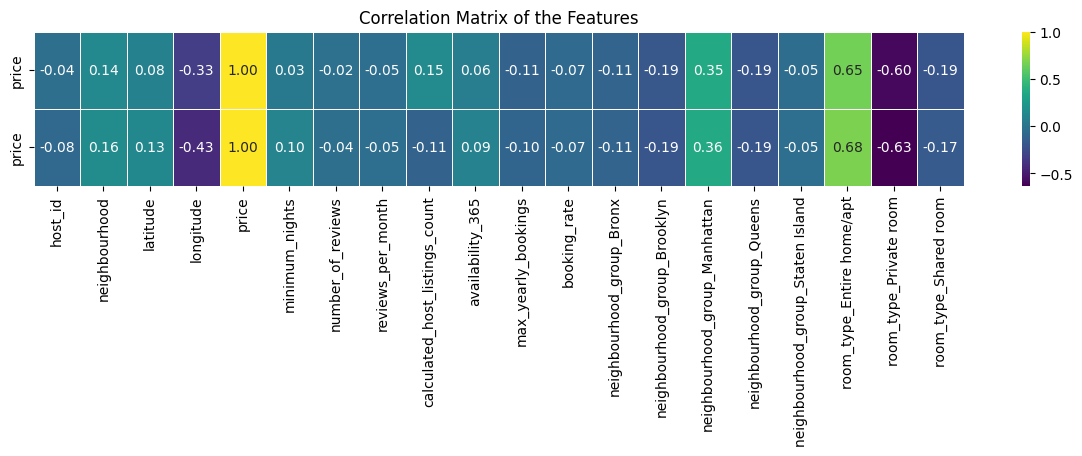

In [27]:
# plot the correlation matrix of the features in the dataset between the price and the other features using the Pearson and Spearman methods
fig, ax = plt.subplots(figsize=(15, 2))
correlation_airbnb = pd.concat([airbnb.corr(method="pearson").loc[["price"]], airbnb.corr(method="spearman").loc[["price"]]])
sns.heatmap(correlation_airbnb, annot=True, fmt='.2f', cmap="viridis", cbar=True, linewidths=0.5, ax=ax)
plt.title("Correlation Matrix of the Features")
plt.show()

The correlation matrix shows the correlation between the different features in the dataset and how they relate to the price of the listings.
We can see that the **room_type_Entire home/apt** has the highest positive correlation with the price, followed by **neighbourhood_group_Manhattan**.
It means that both the neighbourhood group and the room type have a significant impact on the price of the listings.

We will check using the SHAP values to see if the correlation values we have match the actual feature affect on the model prediction.

Also, looking at the new features **booking_rate** and **max_yearly_bookings**, we can see they have a very small correlation to the price. We will see how the models uses these feature and examine their SHAP values.

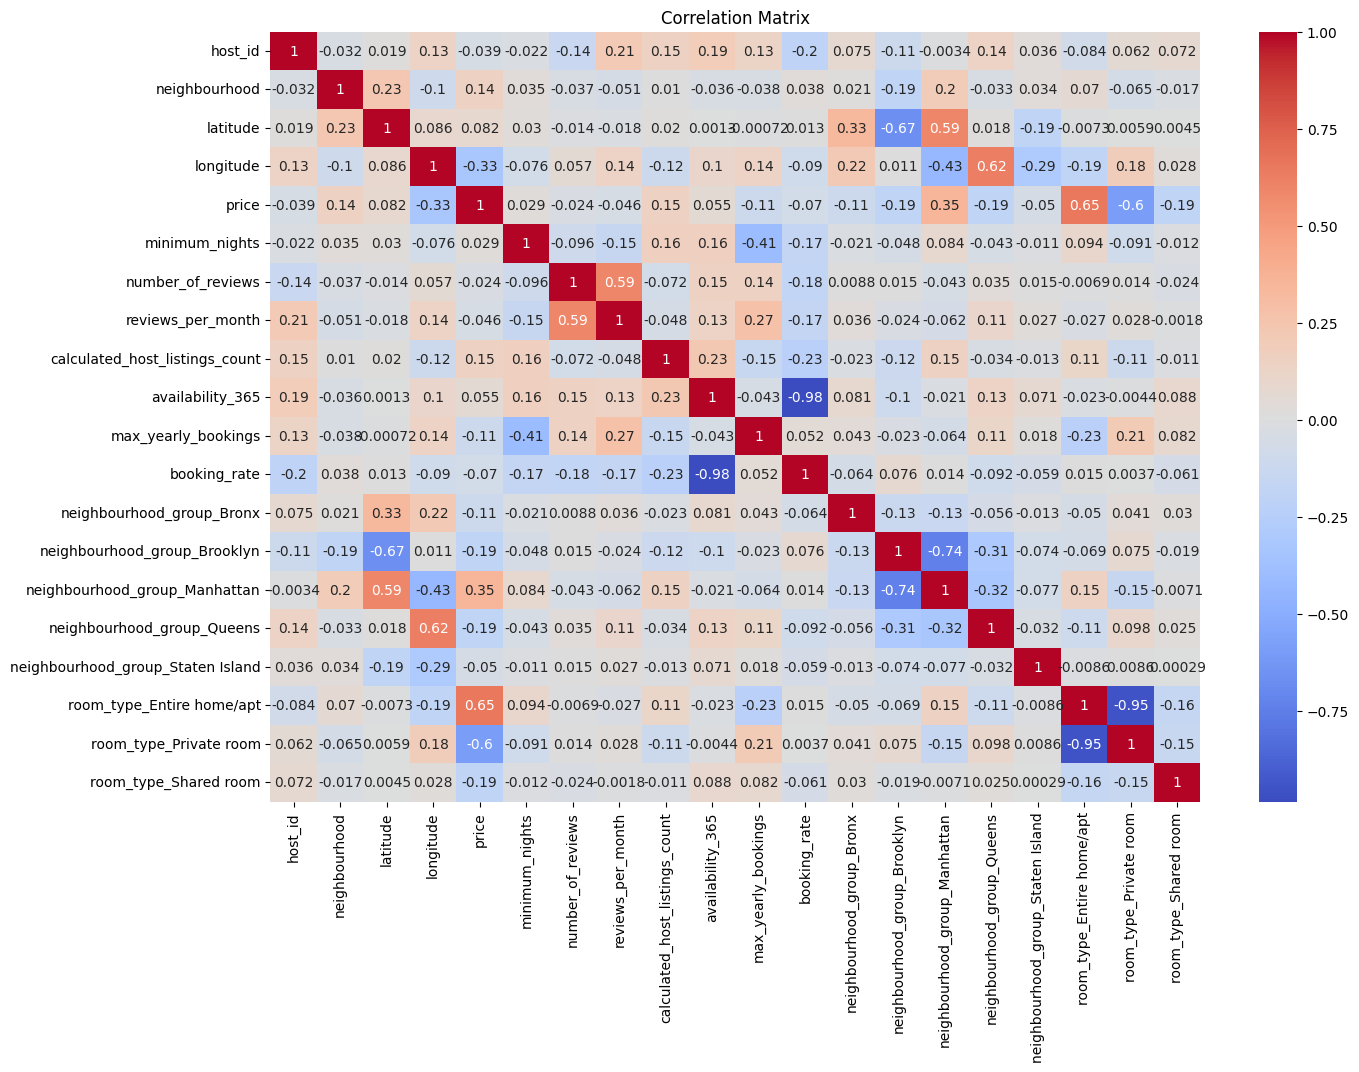

In [28]:
# Calculate the pearson correlation and plot the correlation matrix of all features
plt.figure(figsize=(15, 10))
sns.heatmap(airbnb.corr(method="pearson"), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Dataset Creation

In [29]:
# First we need to split the dataset into features and target variable
X = airbnb.drop(["price"], axis=1)
y = airbnb["price"]

In [30]:
# A look at the features in the dataset after preprocessing, before sending them to the model.
X.head()

,host_id,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,max_yearly_bookings,booking_rate,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2787,107,-1.023459,-0.364274,-0.25,0.173913,-0.108280,5.0,1.000000,365.000000,0,False,True,False,False,False,False,True,False
1,2845,126,0.421913,-0.606415,-0.25,1.739130,0.000000,1.0,0.972603,365.000000,10,False,False,True,False,False,True,False,False
2,4632,93,1.176398,0.282923,0.25,-0.217391,-0.242038,0.0,1.000000,121.666667,0,False,False,True,False,False,False,True,False
3,4869,41,-0.510708,-0.096432,-0.25,11.521739,2.713376,0.0,0.531507,365.000000,171,False,True,False,False,False,True,False,False
4,7192,61,1.033264,0.238530,2.00,0.173913,-0.178344,0.0,0.095890,36.500000,365,False,False,True,False,False,True,False,False


In [31]:
# Split the dataset into training and testing sets with 80/20 ratio.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model
We will build a baseline model to predict the price of the listings based on the features in the dataset.\
This part is just to evaluate the baseline model using our data after preprocessing, and we can compare it to the baseline model performance from Part 2.

In [32]:
models_scores = {}

# Train XGBoost as a baseline model for our pipeline
xgboost_model = XGBRegressor(objective="reg:squarederror")
xgboost_model.fit(X_train, y_train)

# Evaluate the baseline model using the testing set
y_pred = xgboost_model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.07106990781337913
R2 Score: 0.6578808203909913


We have the initial results using our train/test split, but we will use the mean squared error and the R2 score to evaluate the model's prediction using cross-validation process.

In [33]:
# Evaluate the model’s predictive results in a 10 fold cross-validation process using the R2 score and mean squared error
r2_scores = cross_val_score(xgboost_model, X, y, cv=10, scoring="r2")
mse_scores = cross_val_score(xgboost_model, X, y, cv=10, scoring="neg_mean_squared_error")
mse_scores = -mse_scores
print("Cross Validation Results:")
print(f"Mean Squared Error: {np.mean(mse_scores)}, +/- STD: {np.std(mse_scores)}")
print(f"Mean R2 Score: {np.mean(r2_scores)}, +/- STD: {np.std(r2_scores)}")

models_scores["XGBoost"] = {"MSE": np.mean(mse_scores), "R2": np.mean(r2_scores)}

Cross Validation Results:
Mean Squared Error: 0.07588333297597172, +/- STD: 0.007223437264204391
Mean R2 Score: 0.6232090246401938, +/- STD: 0.037539990474314056


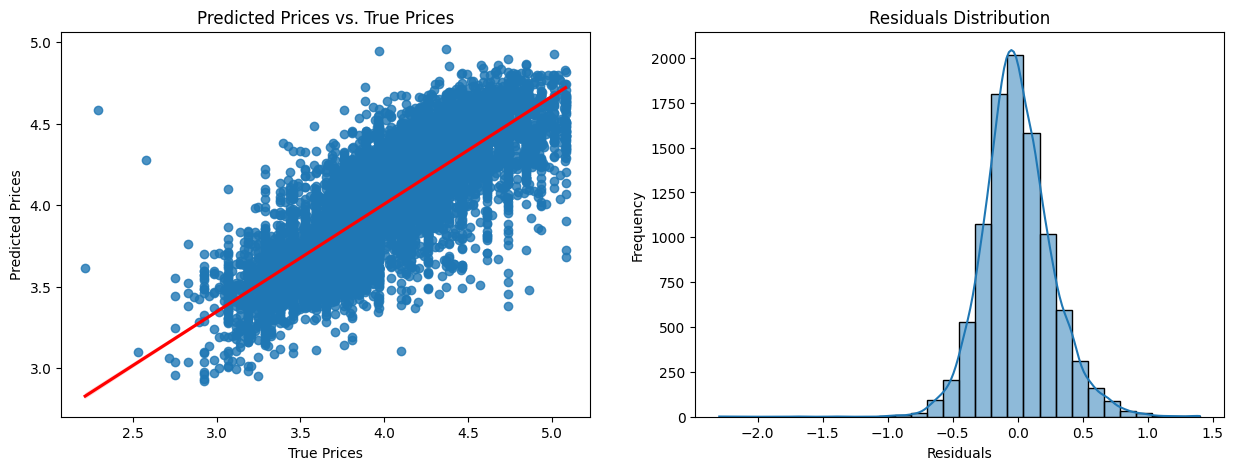

In [34]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=ax1)
ax1.set_title("Predicted Prices vs. True Prices")
ax1.set_xlabel("True Prices")
ax1.set_ylabel("Predicted Prices")

sns.histplot(y_test - y_pred, bins=30, kde=True, ax=ax2)
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Frequency")
plt.show()

The regression plot shows that the majority of the listing in the price range of 3.0 to 5.0 have the less error margin, But listings with smaller or higher prices than that range has bigger error margin, It also could be because of the lower amount of listing in that price range in our dataset.


The residuals distribution plot shows that the residuals are normally distributed around 0, and the residulas are much smaller compared to our first pipline in part 2.\
It seems like the model was able to predict the prices with smaller error.

## SHAP values

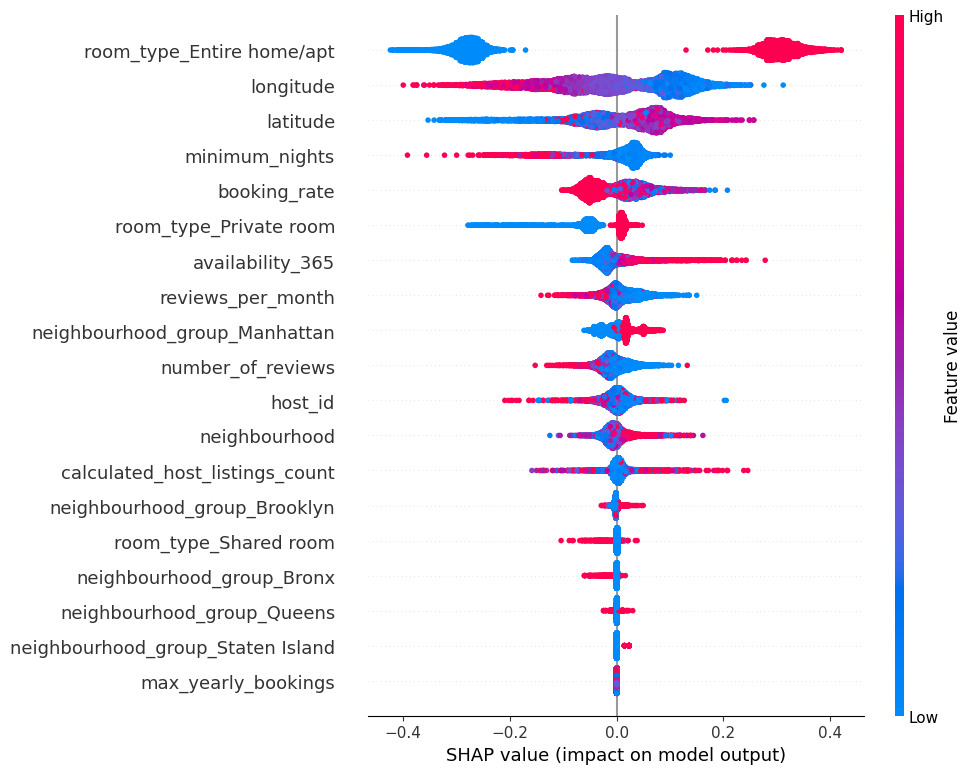

In [35]:
explainer = shap.TreeExplainer(xgboost_model)
explanation = explainer(X_test)
shap.plots.beeswarm(explanation, max_display=20)

As we can see, the most important feature is **room_type_Entire home/apt**, followed by **longtitude**, **latitude**, **availability_365**, etc..\
Together with the correlation matrix described above, we can see that the **room_type_Entire home/apt** is the most important feature both in the correlation and the feature value.\
In addition to that, we can see that **longtitude** and **latitude** also have high effect on the model, where in the previous correlation matrix is has very small value.

The least important feature is **neighborhood_group_Staten_Island**. It probably because of the small amount of Staten Island listings (samples) in the dataset.

For our new feature, we can see that **booking_rate** has high SHAP value, meaning its one of the top 5 features helping the model to predict the listing prices.\
However, the **max_yearly_bookings** feature has the lowest SHAP value, therfore it's not really helping our model prediction, and we can remove it.

## Alternative models

Now we will try a few more models in order to compare the results with our base model (XGBoost) and in the end we will take the one that gives us the best prediction for our problem.

### RandomForestRegressor

In [36]:
if run_alternative_models:
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.07162708419783699
R2 Score: 0.6551986623101227


In [37]:
if run_alternative_models:
    r2_scores = cross_val_score(rf_model, X, y, cv=10, scoring="r2")
    mse_scores = cross_val_score(rf_model, X, y, cv=10, scoring="neg_mean_squared_error")
    mse_scores = -mse_scores
    print("Cross Validation Results:")
    print(f"Mean Squared Error: {np.mean(mse_scores)}, +/- STD: {np.std(mse_scores)}")
    print(f"Mean R2 Score: {np.mean(r2_scores)}, +/- STD: {np.std(r2_scores)}")
    models_scores["RandomForest"] = {"MSE": np.mean(mse_scores), "R2": np.mean(r2_scores)}

Cross Validation Results:
Mean Squared Error: 0.07623574872482922, +/- STD: 0.007007382987651295
Mean R2 Score: 0.6216725171050375, +/- STD: 0.0375450637945478


### CatBoostRegressor

In [38]:
if run_alternative_models:
    cat_model = CatBoostRegressor(verbose=0)
    cat_model.fit(X_train, y_train)
    y_pred = cat_model.predict(X_test)
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.06955960637182297
R2 Score: 0.6651511701922643


In [39]:
if run_alternative_models:
    r2_scores = cross_val_score(cat_model, X, y, cv=10, scoring="r2")
    mse_scores = cross_val_score(cat_model, X, y, cv=10, scoring="neg_mean_squared_error")
    mse_scores = -mse_scores
    print("Cross Validation Results:")
    print(f"Mean Squared Error: {np.mean(mse_scores)}, +/- STD: {np.std(mse_scores)}")
    print(f"Mean R2 Score: {np.mean(r2_scores)}, +/- STD: {np.std(r2_scores)}")
    models_scores["CatBoost"] = {"MSE": np.mean(mse_scores), "R2": np.mean(r2_scores)}

Cross Validation Results:
Mean Squared Error: 0.07369088181378107, +/- STD: 0.006955252870846176
Mean R2 Score: 0.6340083449064154, +/- STD: 0.036737724336906974


### LightGBM

In [40]:
if run_alternative_models:
    lgbm_model = LGBMRegressor(verbose=-1)
    lgbm_model.fit(X_train, y_train)

    y_pred = lgbm_model.predict(X_test)
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.07131362827979525
R2 Score: 0.6567075890109372


In [41]:
if run_alternative_models:
    r2_scores = cross_val_score(lgbm_model, X, y, cv=10, scoring="r2")
    mse_scores = cross_val_score(lgbm_model, X, y, cv=10, scoring="neg_mean_squared_error")
    mse_scores = -mse_scores
    print("Cross Validation Results:")
    print(f"Mean Squared Error: {np.mean(mse_scores)}, +/- STD: {np.std(mse_scores)}")
    print(f"Mean R2 Score: {np.mean(r2_scores)}, +/- STD: {np.std(r2_scores)}")
    models_scores["LightGBM"] = {"MSE": np.mean(mse_scores), "R2": np.mean(r2_scores)}

Cross Validation Results:
Mean Squared Error: 0.07453537569740458, +/- STD: 0.006322019227123291
Mean R2 Score: 0.6297408949612867, +/- STD: 0.03493525978194705


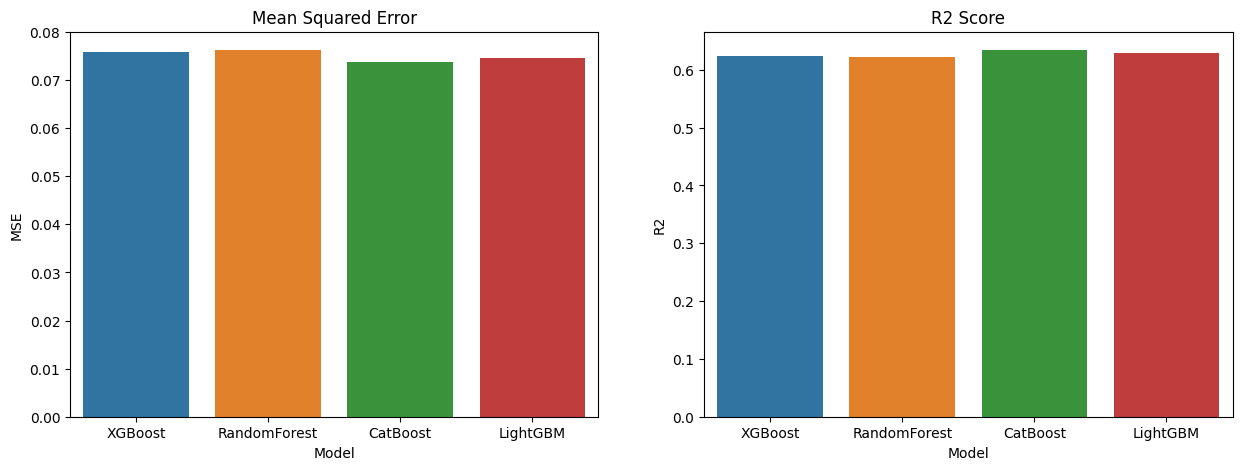

In [42]:
if run_alternative_models:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.barplot(x=list(models_scores.keys()), y=[score["MSE"] for score in models_scores.values()], ax=ax[0], hue=list(models_scores.keys()))
    ax[0].set_title("Mean Squared Error")
    ax[0].set_xlabel("Model")
    ax[0].set_ylabel("MSE")

    sns.barplot(x=list(models_scores.keys()), y=[score["R2"] for score in models_scores.values()], ax=ax[1], hue=list(models_scores.keys()))
    ax[1].set_title("R2 Score")
    ax[1].set_xlabel("Model")
    ax[1].set_ylabel("R2")
    plt.show()

The initial result shows that **CatBoost** has the lowest mean squared error (approx. 0.0694) and the highest R2 score (approx. 0.6658).\
It also has the best cross-validation results: 0.07453 mean squared error and 0.62974 mean R2 score.\
It may indicate that this model will give the best results after the HyperParameter tuning.


In terms of running time, the models listed from the fastest to the slowest:
1. LightGBM 
2. XGBoost
3. CatBoost
4. RandomForest

This may affect our model selection, as in some cases we will prefer faster prediction with lower resource requirements, while in other cases we will prefer the model with the best performance.

## HyperParameter tuning and best model selection

Now we would want to measure the best model more accurately using HyperParameter tuning and we will choose the best model based on this process.

In [43]:
# It takes a lot of time to find the optimized parameters.
if run_hyperparameter_tuning:

    # Initialize the models
    models = [("XGBoost", XGBRegressor(objective='reg:squarederror')),
            ("CatBoost", CatBoostRegressor(verbose=False)),
            ("RandomForest", RandomForestRegressor()),
            ("LightGBM", LGBMRegressor(verbose=-1))]

    # Define the hyperparameters for each model
    param_grids = {
        'XGBoost': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]},
        'CatBoost': {'iterations': [200], 'learning_rate': [0.15, 0.2], 'depth': [10, 15]},
        'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 15, 20]},
        'LightGBM': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}
    }

    # Train and evaluate the models with hyperparameter tuning
    for name, regressor in models:
        print(f"Hyperparameter Tuning for {name}:")
        start_time = time.time()

        if param_grids[name]:
            grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            print(f"Best parameters: {grid_search.best_params_}")
        else:
            best_model = regressor.fit(X_train, y_train)

        # Prediction
        y_pred = best_model.predict(X_test)
        # R^2 score
        r2 = r2_score(y_test, y_pred)
        # MSE
        mse = mean_squared_error(y_test, y_pred)
        # MAE
        mae = mean_absolute_error(y_test, y_pred)
        # Execution time
        execution_time = time.time() - start_time

        print(f"R2 Score: {round(r2, 4)} ({name})")
        print(f"MAE: {round(mae, 4)} ({name})")
        print(f"MSE: {round(mse, 4)} ({name})")
        print(f"Execution Time: {round(execution_time, 2)} seconds\n")

Hyperparameter Tuning for XGBoost:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
R2 Score: 0.6623 (XGBoost)
MAE: 0.2019 (XGBoost)
MSE: 0.0701 (XGBoost)
Execution Time: 5.66 seconds

Hyperparameter Tuning for CatBoost:
Best parameters: {'depth': 10, 'iterations': 200, 'learning_rate': 0.15}
R2 Score: 0.6659 (CatBoost)
MAE: 0.2005 (CatBoost)
MSE: 0.0694 (CatBoost)
Execution Time: 201.09 seconds

Hyperparameter Tuning for RandomForest:
Best parameters: {'max_depth': 15, 'n_estimators': 200}
R2 Score: 0.6592 (RandomForest)
MAE: 0.2016 (RandomForest)
MSE: 0.0708 (RandomForest)
Execution Time: 116.92 seconds

Hyperparameter Tuning for LightGBM:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
R2 Score: 0.6613 (LightGBM)
MAE: 0.2026 (LightGBM)
MSE: 0.0704 (LightGBM)
Execution Time: 40.49 seconds



# Best model

As we can see from the results above, the differences between the models are very small, but the best model is **CatBoost**.

In [44]:
best_catboost = CatBoostRegressor(iterations=200, learning_rate=0.15, depth=10, verbose=False)
best_catboost.fit(X_train, y_train)

y_pred = best_catboost.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.0694035012256346
R2 Score: 0.6659026354212182


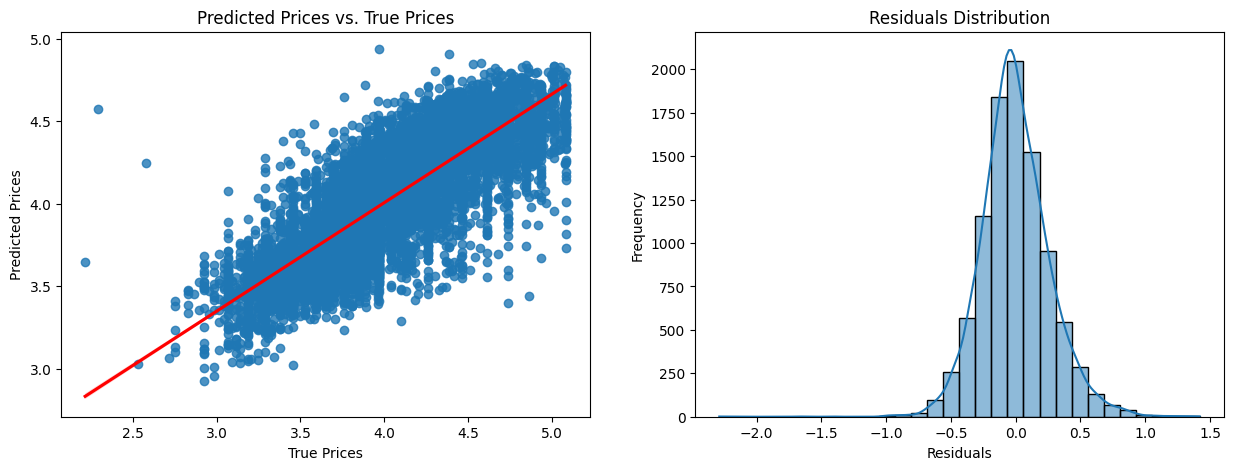

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, ax=ax1)
ax1.set_title("Predicted Prices vs. True Prices")
ax1.set_xlabel("True Prices")
ax1.set_ylabel("Predicted Prices")

sns.histplot(y_test - y_pred, bins=30, kde=True, ax=ax2)
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Frequency")
plt.show()

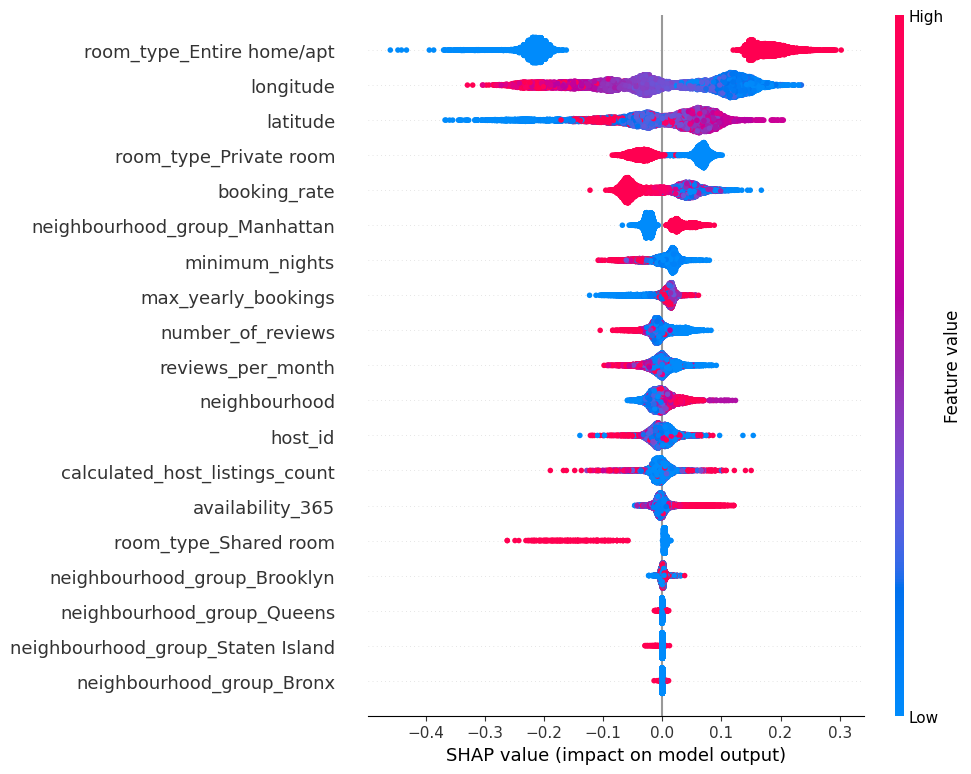

In [46]:
#plot the shap values
explainer = shap.TreeExplainer(best_catboost)
explanation = explainer(X_test)
shap.plots.beeswarm(explanation, max_display=20)

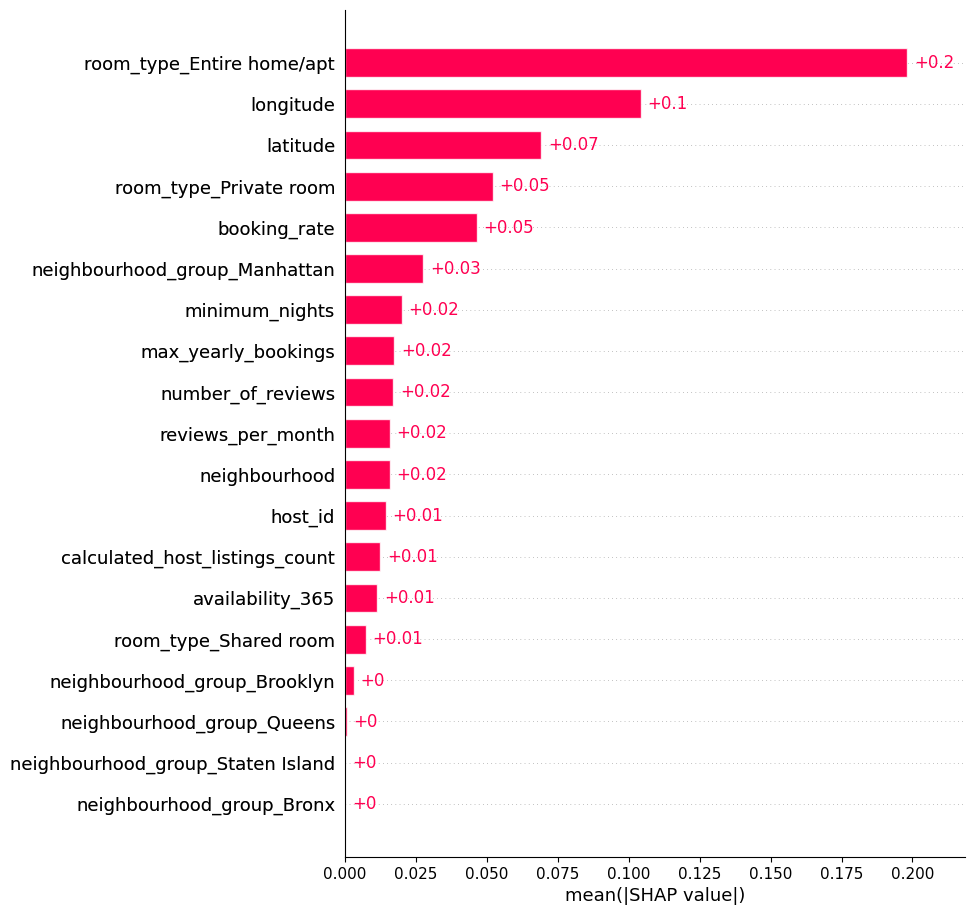

In [47]:
shap.plots.bar(explanation, max_display=20)

As we can see from the **CatBoost** model SHAP values, similar to the baseline **XGBoost** model, the most important feature is **room_type_Entire home/apt**, followed by **longtitude**, **latitude**.\
But we can see that our new feature **max_yearly_bookings** got higher SHAP value than it got with **XGBoost**, while the biggest drop in the SHAP values is for **availability_365** compared to **XGBoost** who gave it higher SHAP value.

The best HyperParameters for the CatBoost model are:
- iterations: 200
- learning_rate: 0.15
- depth: 10

It is possible to find better parameters, but it will require much more compute power.

Overall, this is the best model for our pipeline.

# Results

During the implementation, we tried to use various techniques to improve our prediction accuracy. Most of them eventually succeeded, but some of them didn't so we excluded them at last.

The first thing we did was **feature engineering** to extract 2 additional features: **booking_rate** and **max_yearly_booking**. The first feature indicates how many times a year the listing is booked on average, and the second feature indicates the maximum times a year its possible to book the listing. This feature engineering did manage to improve the prediction accuracy. In addition, We also deleted the listings that have a minimum nights greater than 365 days because they were rare and created noises in our dataset.

In the next phase we also used transformation on the **price** column to deal with skewness by changing the range the model should predict, since the range of (0-500] is quite big. We tried 3 different transformations: **log1p**, **BoxCox** and **Yeo-Johnson**, but eventually chose the **Yeo-Johnson** transormation which slightly improved the prediction accuracy.

A part that did not work as expected is **Data Imptutation**. The **availability_365** feature may contain missing information and sometime shows invalid values, so we tried to use **KNN Imputation** to fill in the missing values based on clustering algorithm. Unfortunately, it did not work as expected and we even got a performance drop so we decided to abandon this technique, and instead filled in the missing values with the **median** of each group, which actually worked and improved our accuracy.

We also used **categorial features embedding**. First we tried to implement embedding vector using **Word2Vec** to the **neighborhood** feature because it have many different catagories, but we saw a degradation in the performence, so we decided to use **Label Encoding** for the **neighborhood** which have many labels, and implemented **One-Hot Encoding** on the **neighborhood_group** and **room_type** features, as they have smaller amount of labels, which improved our prediction accuracy. Additionaly, we normalized the availability_365 column by diving it by 365, and used **RobustScaler** on the rest of the numeric features.

Finally, we compared 4 models on our prediction problem with a HyperParamater Tuning proccess: 
- **XGBoost**
- **CatBoost**
- **LightGBM**
- **RandomForest**

The best model we achieved was **CatBoost**, with a very small difference from the rest of the models.

In summary, the model we chose to use to solve our prediction problem is **CatBoost** which after the Hyper Parameter Tuning process achieved a Mean Squared Error of 0.0694035 and an R2 Score of 0.6659026. The selected hyperparameters are: 
- **iterations**: 200
- **learning rate**: 0.15 
- **depth**: 10

Compraing our work to the baseline model from part 2, we can see that our model performance outperform the baseline model, as we done additional feature engineering and implemented different data processing methods to make the data more "readable" by the model to improve the performance.
Also, looking at related work done online on the same dataset, we tried to implement uniqe processing methods we haven't seen in any other work, for example the KNN Imputation to fill the missing values, or the Word2Vec embedding method on the textual features.

# References

- [Kaggle - New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/code)
- [Aditya Ahuja, Aditya Lahiri, Aniruddha Das - Predicting Airbnb Rental Prices Using Multiple Feature Modalities](https://arxiv.org/pdf/2112.06430)
- [Pouya Rezazadeh Kalehbasti, Liubov Nikolenko, Hoormazd Rezaei - Airbnb Price Prediction Using Machine Learning and Sentiment Analysis](https://arxiv.org/pdf/1907.12665)
- [Piotr Florek, Adam Zagdański - Benchmarking state-of-the-art gradient boosting algorithms for classification](https://arxiv.org/pdf/2305.17094)